  SIG_KOR_NM  centroid_lat  centroid_lon  isSchool  rental_count  \
0        강서구     37.555328    126.765147         0           0.0   
1        강서구     37.555768    126.765465         0           0.0   
2        강서구     37.555308    126.766217         0           0.0   
3        강서구     37.555945    126.766239         0           0.0   
4        강서구     37.552600    126.768528         0           0.0   

   return_count  apart  closest_hospital_dist  closest_convenience_dist  \
0           0.0    0.0               7.955399                  8.020145   
1           0.0    0.0               7.941459                  8.007402   
2           0.0    0.0               7.923215                  7.989793   
3           0.0    0.0               7.915868                  7.983490   
4           0.0    0.0               7.889078                  7.911432   

   closest_culture_dist  ...  subway_avg_board  subway_avg_alight  area20  \
0              8.518302  ...               0.0                0

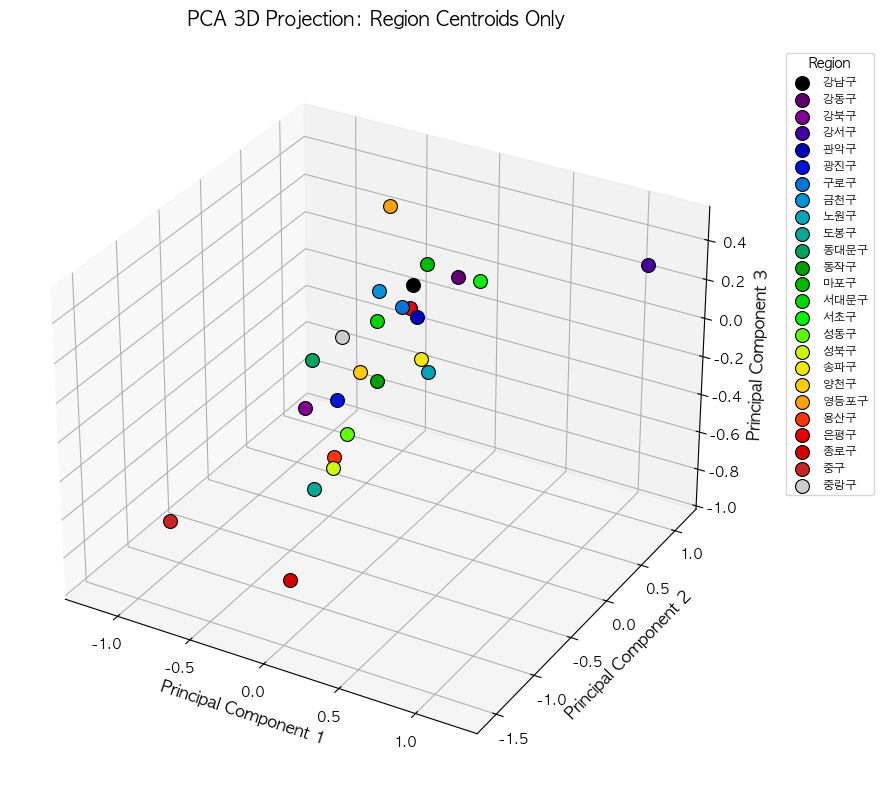

In [5]:
# ============================================================
# 1. 라이브러리 불러오기 및 한글 폰트 설정
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D   # 3D 시각화용

# 한글 폰트 깨짐 방지
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# 2. 데이터 불러오기
# ============================================================
df = pd.read_csv("seoul_preprocessed-2.csv")
print(df.head())

# ============================================================
# 3. SIG_KOR_NM 전처리: 공백 제거 및 결측치 제외 (필요 시)
# ============================================================
df['SIG_KOR_NM'] = df['SIG_KOR_NM'].astype(str).str.strip()
df = df[df['SIG_KOR_NM'] != '']          
df = df.dropna(subset=['SIG_KOR_NM'])      

# ============================================================
# 4. 특정 지역구(동작구, 구로구) 제외
# ============================================================
"""
exclude_list = ['동작구', '구로구']
df = df[~df['SIG_KOR_NM'].isin(exclude_list)].copy()
"""

# ============================================================
# 5. 사용할 피처 정의 (tow_count 제외)
# ============================================================
features = [
    'closest_hospital_dist', 'closest_culture_dist', 'age_20s',
    'age_30s', 'age_40s', 'closest_cross_dist', 'closest_bus_dist',
    'closest_subway_dist', 'closest_convenience_dist'
]

# ============================================================
# 6. 피처에 결측치 있는 행 제거
# ============================================================
df = df.dropna(subset=features).copy()

# ============================================================
# 7. 피처 행렬(X) / 라벨(labels) 준비
# ============================================================
X = df[features].astype(float).values
labels = df['SIG_KOR_NM'].values

# ============================================================
# 8. 전체 피처에 대해 로그 변환 → z-score(StandardScaler) 변환
# ============================================================
# 8-2) StandardScaler로 z-score 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================================================
# 9. PCA → 3차원으로 축소
# ============================================================
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# ============================================================
# 10. 지역구별 PCA 좌표 DataFrame 생성
# ============================================================
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df_pca['Region'] = labels

# ============================================================
# 11. 지역구별 “PCA centroid” 계산
# ============================================================
region_centroids = (
    df_pca
    .groupby('Region')[['PC1', 'PC2', 'PC3']]
    .mean()
    .reset_index()
)

# ============================================================
# 12. 전체 샘플의 PCA 평균(Overall Centroid) 계산
# ============================================================
overall_centroid = df_pca[['PC1', 'PC2', 'PC3']].mean().values

# ============================================================
# 13. 전체 중심 기준 거리 계산 (Dist_from_overall)
# ============================================================
region_centroids['Dist_from_overall'] = region_centroids.apply(
    lambda row: np.linalg.norm(
        np.array([row['PC1'], row['PC2'], row['PC3']]) - overall_centroid
    ),
    axis=1
)
# ============================================
# 14. (새) 3D 산점도: "지역구별 중심점"만 표시
# ============================================
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

unique_regions = region_centroids['Region'].tolist()
n_regions = len(unique_regions)

# 컬러맵 설정: 지역구 개수가 20개 이하면 'tab20', 넘으면 'nipy_spectral'
if n_regions <= 20:
    cmap = plt.get_cmap('tab20', n_regions)
else:
    cmap = plt.get_cmap('nipy_spectral', n_regions)

region_to_color = {region: cmap(i) for i, region in enumerate(unique_regions)}

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# (1) 각 지역구별 중심점 위치(PC1, PC2, PC3)만 그리기
for i, row in region_centroids.iterrows():
    reg = row['Region']
    cx, cy, cz = row['PC1'], row['PC2'], row['PC3']
    ax.scatter(
        cx, cy, cz,
        color=region_to_color[reg],
        s=100,
        marker='o',
        edgecolors='black',
        linewidths=0.8,
        label=reg
    )

# (2) 그래프 설정
ax.set_title("PCA 3D Projection: Region Centroids Only", fontsize=14, pad=15)
ax.set_xlabel("Principal Component 1", fontsize=12)
ax.set_ylabel("Principal Component 2", fontsize=12)
ax.set_zlabel("Principal Component 3", fontsize=12)

# (3) 범례 설정: 중복 제거
handles, labels_legend = ax.get_legend_handles_labels()
unique = dict(zip(labels_legend, handles))
ax.legend(
    unique.values(),
    unique.keys(),
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    fontsize='small',
    title='Region',
    ncol=1
)

plt.tight_layout()
plt.show()

In [8]:
# ============================================================
# 15. Overall Centroid로부터 가장 멀리 떨어진 5개 구 찾기
# ============================================================
from IPython.display import display

# region_centroids에는 이미 'Region' , 'Dist_from_overall' 컬럼이 있습니다.
top5 = (
    region_centroids
    .sort_values('Dist_from_overall', ascending=False)
    .head(5)
    .reset_index(drop=True)
)

print("Overall Centroid로부터 가장 멀리 떨어진 5개 지역구:")
display(top5[['Region', 'Dist_from_overall']])

Overall Centroid로부터 가장 멀리 떨어진 5개 지역구:


,Region,Dist_from_overall
0,중구,1.692935
1,도봉구,1.574392
2,강서구,1.529585
3,종로구,1.401857
4,강남구,1.238217


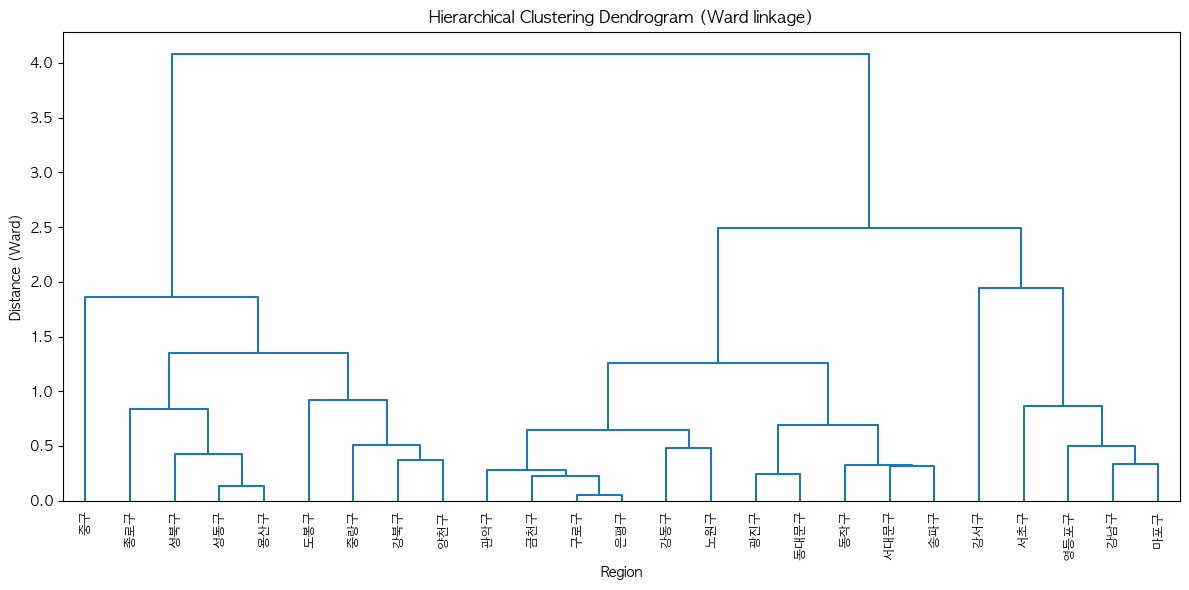

=== Clusters (k=5) ===
Cluster 1: 강북구, 도봉구, 성동구, 성북구, 양천구, 용산구, 종로구, 중랑구
Cluster 2: 중구
Cluster 3: 강동구, 관악구, 광진구, 구로구, 금천구, 노원구, 동대문구, 동작구, 서대문구, 송파구, 은평구
Cluster 4: 강남구, 마포구, 서초구, 영등포구
Cluster 5: 강서구



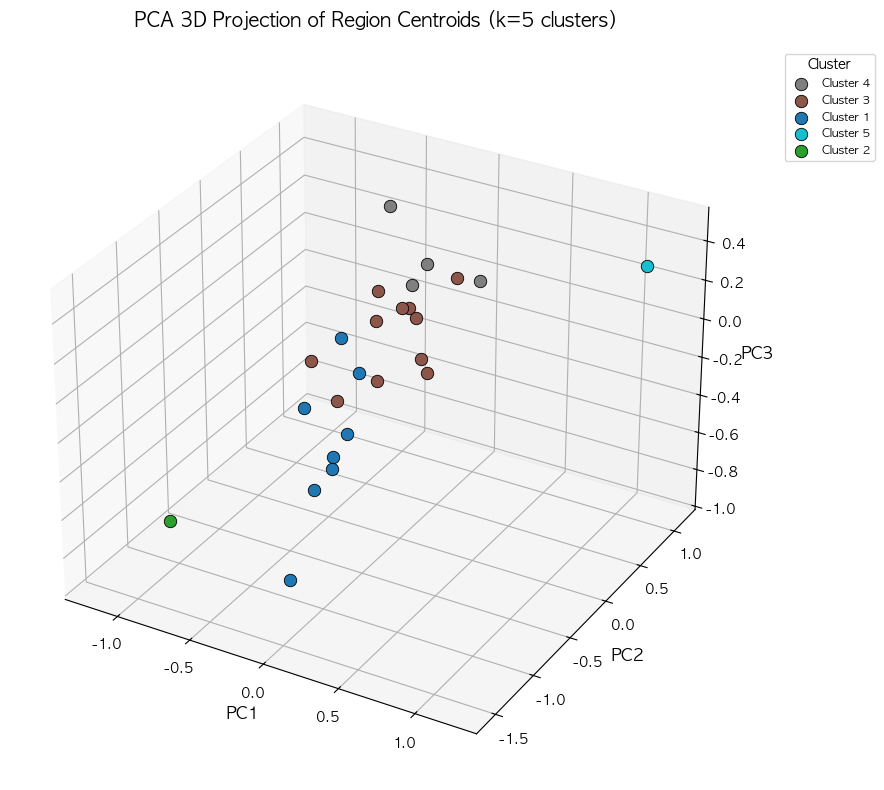

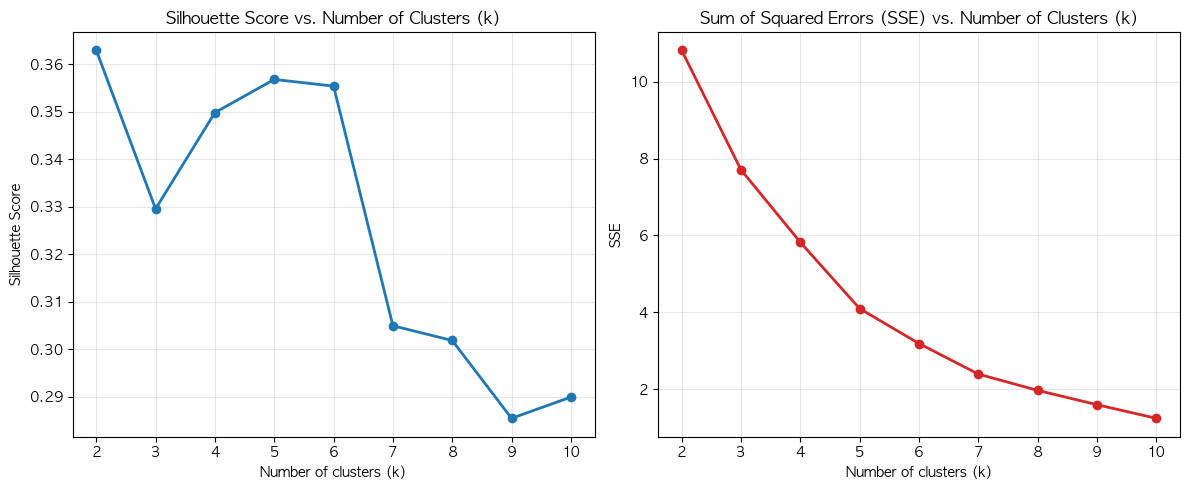

In [6]:
# ============================================================
# 1. 라이브러리 불러오기
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from mpl_toolkits.mplot3d import Axes3D  # 3D 시각화용
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# ============================================================
# 2. 준비: region_centroids DataFrame 로드 (이미 계산된 상태 가정)
#    - region_centroids에는 각 Region별 PCA 3D 좌표(PC1, PC2, PC3)가 있음
#    예시 컬럼: ['Region', 'PC1', 'PC2', 'PC3', ...]
# ============================================================
# (예: 이전 단계에서 만든 region_centroids를 그대로 사용)
# region_centroids = pd.read_csv("path_to_region_centroids.csv")  # 이미 생성되어 있다면 주석 처리

df_seoul = pd.read_csv("seoul_preprocessed.csv")

X_centroids = region_centroids[['PC1', 'PC2', 'PC3']].values
region_names = region_centroids['Region'].tolist()

# ※ PCA 단계에서 이미 z-score를 적용했다면, 추가 스케일링은 생략해도 됩니다.
#    만약 재스케일링이 필요하다면 아래 주석을 해제하세요.
# scaler = StandardScaler()
# X_centroids = scaler.fit_transform(X_centroids)

# ============================================================
# 3. 계층적 군집화용 linkage 행렬 계산 (Ward linkage)
# ============================================================
Z = linkage(X_centroids, method='ward')

# ============================================================
# 4. 덴드로그램 시각화
# ============================================================
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=region_names,
    leaf_rotation=90,
    leaf_font_size=9,
    color_threshold=0  # 한 색으로 표시
)
plt.title("Hierarchical Clustering Dendrogram (Ward linkage)")
plt.xlabel("Region")
plt.ylabel("Distance (Ward)")
plt.tight_layout()
plt.show()

# ============================================================
# 5. 클러스터 개수(k) 선택 및 할당 (예: k = 4)
#    fcluster를 통해 linkage 결과에서 최대 k개 클러스터로 자름
# ============================================================
k = 5
cluster_labels = fcluster(Z, t=k, criterion='maxclust')
region_centroids['Cluster'] = cluster_labels

# ============================================================
# 6. 각 클러스터에 속한 지역구 이름 출력
# ============================================================
print(f"=== Clusters (k={k}) ===")
for c_id in sorted(region_centroids['Cluster'].unique()):
    members = region_centroids.loc[region_centroids['Cluster'] == c_id, 'Region'].tolist()
    print(f"Cluster {c_id}: {', '.join(members)}")
print()

# ============================================================
# 7. 3D 산점도: PCA 3차원 공간 위에 “지역구별 중심점”을 군집별 색깔로 표시
# ============================================================
unique_clusters = sorted(region_centroids['Cluster'].unique())
n_clusters = len(unique_clusters)

# 컬러맵 설정
if n_clusters <= 10:
    cmap = plt.get_cmap('tab10', n_clusters)
else:
    cmap = plt.get_cmap('nipy_spectral', n_clusters)
cluster_to_color = {c: cmap(i) for i, c in enumerate(unique_clusters)}

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for _, row in region_centroids.iterrows():
    c_id = row['Cluster']
    cx, cy, cz = row['PC1'], row['PC2'], row['PC3']
    ax.scatter(
        cx, cy, cz,
        color=cluster_to_color[c_id],
        s=80,
        marker='o',
        edgecolors='black',
        linewidths=0.6,
        label=f"Cluster {c_id}"
    )

ax.set_title(f"PCA 3D Projection of Region Centroids (k={k} clusters)", pad=15, fontsize=14)
ax.set_xlabel("PC1", fontsize=12)
ax.set_ylabel("PC2", fontsize=12)
ax.set_zlabel("PC3", fontsize=12)

# 범례 중복 제거
handles, labels_legend = ax.get_legend_handles_labels()
unique = dict(zip(labels_legend, handles))
ax.legend(
    unique.values(),
    unique.keys(),
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    fontsize='small',
    title='Cluster',
    ncol=1
)

plt.tight_layout()
plt.show()

# ============================================================
# 8. k 값을 2부터 max_k까지 바꿔가며 Silhouette Score 및 SSE 계산
# ============================================================
max_k = min(10, len(X_centroids) - 1)  # 원본 지역구 개수에 맞춰 조정
ks = list(range(2, max_k + 1))

sil_scores = []
sse_list = []

for k_val in ks:
    # (1) 계층적 군집화(ward) → 클러스터 할당
    model = AgglomerativeClustering(n_clusters=k_val, linkage='ward')
    labels_k = model.fit_predict(X_centroids)
    
    # (2) Silhouette Score 계산
    sil = silhouette_score(X_centroids, labels_k)
    sil_scores.append(sil)
    
    # (3) SSE 계산: 각 클러스터 내 중심점 간 거리 제곱합
    sse = 0.0
    for cluster_id in range(k_val):
        members = X_centroids[labels_k == cluster_id]
        if members.size == 0:
            continue
        centroid = members.mean(axis=0)
        sse += np.sum((np.linalg.norm(members - centroid, axis=1)) ** 2)
    sse_list.append(sse)

# ============================================================
# 9. Silhouette Score & SSE 시각화
# ============================================================
plt.figure(figsize=(12, 5))

# (a) Silhouette Score Plot
plt.subplot(1, 2, 1)
plt.plot(ks, sil_scores, marker='o', linewidth=2, color='tab:blue')
plt.xticks(ks)
plt.title("Silhouette Score vs. Number of Clusters (k)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(alpha=0.3)

# (b) SSE Plot
plt.subplot(1, 2, 2)
plt.plot(ks, sse_list, marker='o', linewidth=2, color='tab:red')
plt.xticks(ks)
plt.title("Sum of Squared Errors (SSE) vs. Number of Clusters (k)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


=== Cluster Centroids ===
   Cluster       PC1       PC2       PC3
0        1 -0.009207 -0.911823 -0.190297
1        2 -1.190817 -0.779242 -0.916932
2        3 -0.030430 -0.053039  0.060909
3        4 -0.284298  0.906694  0.096318
4        5  1.220134  0.835284  0.391413


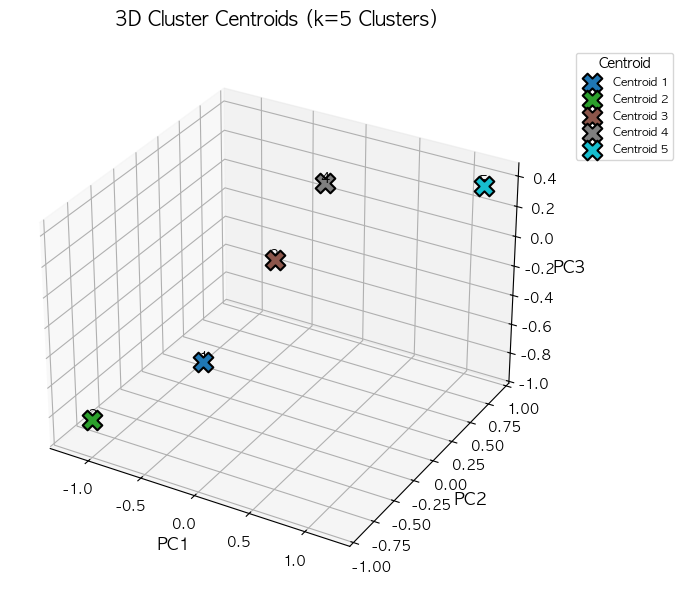

In [7]:
# 10. 각 클러스터별 중점(Centroid) 계산
cluster_centroids = (
    region_centroids
    .groupby('Cluster')[['PC1', 'PC2', 'PC3']]
    .mean()
    .reset_index()
)

# 각 클러스터 중점 출력
print("=== Cluster Centroids ===")
print(cluster_centroids)

# 11. 3D 산점도: 클러스터 중점 시각화 (X 마커)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for _, row in cluster_centroids.iterrows():
    c_id = int(row['Cluster'])
    cx, cy, cz = row['PC1'], row['PC2'], row['PC3']
    ax.scatter(
        cx, cy, cz,
        color=cluster_to_color[c_id],
        s=200,
        marker='X',
        edgecolors='black',
        linewidths=1.5,
        label=f"Centroid {c_id}"
    )
    # 클러스터 번호 텍스트 라벨링
    ax.text(cx, cy, cz, f"{c_id}", color='black', fontsize=10, horizontalalignment='center')

ax.set_title(f"3D Cluster Centroids (k={k} Clusters)", pad=15, fontsize=14)
ax.set_xlabel("PC1", fontsize=12)
ax.set_ylabel("PC2", fontsize=12)
ax.set_zlabel("PC3", fontsize=12)

# 범례 중복 제거
handles, labels_legend = ax.get_legend_handles_labels()
unique = dict(zip(labels_legend, handles))
ax.legend(
    unique.values(),
    unique.keys(),
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    fontsize='small',
    title='Centroid',
    ncol=1
)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# (1) df_sample 준비
df_sample = df.copy()
df_sample = df.sample(frac=0.2, random_state=42)

# (2) PCA용 피처 추출→ 스케일링→ PCA 투영
X_sample       = df_sample[features].copy()
X_sample_scaled= scaler.transform(X_sample)
X_sample_pca   = pca.transform(X_sample_scaled)   # shape: (n_samples, 3)

# (3) 클러스터 중심 좌표 불러오기
cluster_ids      = cluster_centroids['Cluster'].values
centroid_vectors = cluster_centroids[['PC1','PC2','PC3']].values.astype(float)
n_samples  = X_sample_pca.shape[0]
n_clusters = centroid_vectors.shape[0]

# (4) 거리 행렬 계산
dists_matrix = np.zeros((n_samples, n_clusters), dtype=float)
for i in range(n_clusters):
    c_vec = centroid_vectors[i]
    dists_matrix[:, i] = np.linalg.norm(X_sample_pca - c_vec, axis=1)

# (4-1) 거리 분포 확인
mean_dist = np.mean(dists_matrix)
std_dist  = np.std(dists_matrix)
print(f"거리 평균: {mean_dist:.2f}, 거리 표준편차: {std_dist:.2f}")

# (5) RBF 방식 가중치 계산
sigma = 10    # 예: 대략 50 / 2 = 25
# 혹은 직접 실험: sigma = 10, 15, 20, 25, 30 등

exp_vals = np.exp(- (dists_matrix ** 2) / (2 * sigma ** 2))   # (n_samples, n_clusters)
weights_rbf = exp_vals / exp_vals.sum(axis=1, keepdims=True)  # (n_samples, n_clusters)

# (6) df_sample에 새 컬럼으로 추가
for idx, c_id in enumerate(cluster_ids):
    df_sample[f'weight_rbf_to_centroid_{c_id}'] = weights_rbf[:, idx]

# (7) 결과 확인
print(df_sample.head(50))
df_sample.to_csv("weight_list.csv", index=True)
